# DOG BREED IDENTIFICATION TASK

# Solution using Convolutional Neural Networks witH Keras

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd 
from os import listdir
from os.path import basename,join,exists
import os
print(listdir("../input"))
import threading
from queue import Queue
from math import floor
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

['labels.csv', 'train', 'test', 'sample_submission.csv']


In [2]:
df = pd.read_csv('../input/sample_submission.csv')
train_dir_path = "../input/train"
test_dir_path = "../input/test"
#pickled_dir_path  = "../output/pickled_Data"
labels_df = pd.read_csv('../input/labels.csv')
dog_breeds = list(df.columns[1:])
print(len(dog_breeds))
print(dog_breeds)

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', '

In [3]:
train_img_fpaths = [ join(train_dir_path, f) for f in listdir(train_dir_path)]
test_img_fpaths = [join(test_dir_path, f) for f in listdir(test_dir_path)]
print(len(train_img_fpaths))
print(len(test_img_fpaths))

10222
10357


In [4]:
def dog_breed_from_id(dog_id):
    #labels_df = pd.read_csv('../input/labels.csv')
    return labels_df[labels_df['id'] ==dog_id]['breed'].values

In [5]:
import cv2 as cv
import numpy as np

In [6]:
# variables 
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_CHANNELS = 3
BATCH_SIZE = 500
lock = threading.Lock()

In [7]:
def img_to_array(img_path):   
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_array.reshape(-1,IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS)
    return img_array

In [8]:
# initialize queue which is threadsafe 
def initialize_queue():
    queue =Queue()
    return queue

In [9]:
# get list of image ids from names of test images
def get_test_image_ids():
    return [basename(fpath).split('.')[0] for fpath in test_img_fpaths]

In [10]:
# converts image files to numpy array and based on train/test, return train array and labels,
def get_data(is_train):
    # 1 batch per thread and last thread with remaining images
    img_fpaths = train_img_fpaths if is_train else test_img_fpaths
    num_threads = floor(len(img_fpaths)/BATCH_SIZE)
    print("num of threads:", num_threads + 1)
    img_array = None
    queue = initialize_queue()
    results = []          # results from multiple threads
    print("getting training data....") if is_train else print("getting testing data....")
    
    # load queue with data for each task
    for batch_index in range(num_threads + 1):
        if batch_index == num_threads:
            file_batch = img_fpaths[(batch_index*BATCH_SIZE):]
        else:
            file_batch = img_fpaths[(batch_index*BATCH_SIZE) : (batch_index + 1)*BATCH_SIZE]
        queue.put(file_batch)
    
    # iterate over loop to create threads
    for thread_index in range(num_threads+1):
        thread = threading.Thread(target = get_train_data_parallely, args=(queue, results)) if is_train else threading.Thread(target =get_testing_data_parallely, args =(queue, results))    
        thread.start()
        print("{} started".format(thread.name))
       # worker_threads.append(thread)
        
    # when queue in empty
    queue.join()
    return results

In [11]:
# convert training data into list of tuples
# this subroutine represents a task for child thread to collect training data
def get_train_data_parallely(queue, results):
    result = []
    while not queue.empty():
        fpaths = queue.get()
        for f_path in fpaths:
            img_array = img_to_array(f_path)
            # train_img_array = img_array if train_img_array is None else np.vstack((train_img_array, img_array))
            img_name = basename(f_path)
            img_id = img_name.split('.')[0]
            dog_breed = dog_breed_from_id(img_id)
            #train_labels.append(dog_breed)
            results.append((img_array, dog_breed))
            
    # append arr,labels for current task to results
    print("{} finished".format(threading.currentThread().getName()))
    # signal for task has been done
    queue.task_done()

In [12]:
# worker job for converting test imgs to array
def get_testing_data_parallely(queue, results):
    while not queue.empty():
        file_batch = queue.get()
        for f_path in file_batch:        
            img_name = basename(f_path)
            img_id = img_name.split('.')[0]
            results.append((img_id, img_to_array(f_path)))
    print("{} finished".format(threading.currentThread().getName()))
    queue.task_done()

In [13]:
# method for getting training data
def get_training_data():
    train_results = get_data(is_train = True)
    train_labels = []
    img_arrays= []
    for u_index in range(len(train_results)):
        img_arr, identified_breed = train_results[u_index]
        img_arrays.append(img_arr)
        train_labels.append(identified_breed)
    train_arr = np.array(img_arrays).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    train_arr = train_arr/255
    train_labels = one_hot_encode_labels(train_labels)
    return train_arr,train_labels

In [14]:
# method for getting testing arr
def get_testing_data():
    results = get_data(is_train = False)
    test_img_ids = []
    test_img_list = []
    for test_result in results:
        img_id, img_arr = test_result
        test_img_list.append(img_arr)
        test_img_ids.append(img_id)
    test_img_arr = np.array(test_img_list).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    test_img_arr = test_img_arr/255
    return test_img_arr, test_img_ids

In [15]:
def save_obj_to_disk(fname, obj):
    print("saving "+ fname +" to filesystem")
    if  exists(fname):
        print(fname + "already exists") 
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)

In [16]:
def load_obj_from_disk(fname):
    if exists(fname):
        print("loading "+fname + " from filesystem")
        obj = None
        with open(fname, 'rb') as f:
            obj = pickle.load(f)
        return obj
    else:
        print(fname + "doesnt not exists")

In [17]:
def load_train_test_data(load_train=False, load_test=False, one_hot_encode=False):
    train_arr = None
    train_labels = None
    test_arr = None
    
    # check if training data and labels exists already as pickled file
    if load_train:
        if exists("train_data.pickle") and exists("train_labels.pickle"):
            train_arr = load_obj_from_disk("train_data.pickle")
            train_labels = load_obj_from_disk("train_labels.pickle")
            if one_hot_encode:
                train_labels = one_hot_encode_labels(train_labels)
        else:
            # create training_data and save it to filesystem
            train_arr, train_labels = get_data(is_train= True)
            if not exists("train_data.pickle"):
                save_obj_to_disk("train_data.pickle", train_data)
            if not exists("train_labels.pickle"):
                save_obj_to_disk("train_labels.pickle", train_labels)
        print(" train array shape : {}, train array labels: {}".format(train_data.shape,len(train_labels)))
        
    # check if testing data and labels exists already as pickled file
    if load_test:
        if exists("test_data.pickle"):
            test_arr = load_obj_from_disk("test_data.pickle")
        else:
            # create test_data and save it to filesystem
            test_arr = get_data(is_train= False)
            save_obj_to_disk("test_data.pickle", test_arr)
        print(" test array shape : {}".format(test_arr.shape))
    return train_arr, train_labels, test_arr

In [18]:
# method for onehot encoding labels of train_arr
def one_hot_encode_labels(label_arr):
    from sklearn.preprocessing import LabelEncoder ,OneHotEncoder
    labelEncoder = LabelEncoder()
    integer_encoded = labelEncoder.fit_transform(np.array(label_arr))
    integer_encoded = integer_encoded.reshape(-1,1)
    onehotEncoder = OneHotEncoder()
    onehot_encoded_arr = onehotEncoder.fit_transform(integer_encoded).toarray()
    return onehot_encoded_arr

In [19]:
train_x, train_y =get_training_data()

num of threads: 21
getting training data....
Thread-5 started
Thread-6 started
Thread-7 started
Thread-8 started
Thread-9 started
Thread-10 started
Thread-11 started
Thread-12 started
Thread-13 started
Thread-14 started
Thread-15 started
Thread-16 started
Thread-17 started
Thread-18 started
Thread-19 started
Thread-20 started
Thread-21 started
Thread-22 started
Thread-23 started
Thread-24 started
Thread-25 started
Thread-25 finished
Thread-14 finished
Thread-8 finished
Thread-10 finished
Thread-13 finished
Thread-17 finished
Thread-16 finished
Thread-9 finished
Thread-19 finished
Thread-22 finished
Thread-18 finished
Thread-21 finished
Thread-5 finished
Thread-15 finished
Thread-23 finished
Thread-7 finished
Thread-6 finished
Thread-12 finished
Thread-20 finished
Thread-11 finished
Thread-24 finished


In [20]:
test_x, test_img_ids = get_testing_data()

num of threads: 21
getting testing data....
Thread-26 started
Thread-27 started
Thread-28 started
Thread-29 started
Thread-30 started
Thread-31 started
Thread-32 started
Thread-33 started
Thread-34 started
Thread-35 started
Thread-36 started
Thread-37 started
Thread-38 started
Thread-39 started
Thread-40 started
Thread-41 started
Thread-42 started
Thread-43 started
Thread-44 started
Thread-45 started
Thread-46 started
Thread-46 finished
Thread-27 finished
Thread-41 finished
Thread-40 finished
Thread-34 finished
Thread-43 finished
Thread-39 finished
Thread-30 finished
Thread-42 finished
Thread-32 finished
Thread-28 finished
Thread-26 finished
Thread-45 finished
Thread-37 finished
Thread-35 finished
Thread-31 finished
Thread-44 finished
Thread-36 finished
Thread-29 finished
Thread-33 finished
Thread-38 finished


In [21]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(len(test_img_ids))

(10222, 150, 150, 3)
(10222, 120)
(10357, 150, 150, 3)
10357


In [22]:
# import required packages
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [23]:
# CNN model
model = Sequential()

# -----------------------------------------------------------------------------------
# conv 1
model.add(Conv2D(16, (3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))       # input -N,150,150,3, output- N,148,148,16
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# max pool 1
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                                   #input- N,148,148,16, output- N, 74,74,16

# -----------------------------------------------------------------------------------
# # conv 2
model.add(Conv2D(32, (3,3)))                                                         #input- N,74,74,16 output - N, 72,72,16
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# max pool 2
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                                 #input - N,72,72,16, output- N,36,36,16
# -----------------------------------------------------------------------------------

# conv 3
model.add(Conv2D(48, (3,3)))                                                       #input - N,36,36,16, output- N,34,34,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.7))

# max pool 3
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                                #input- N,34,34,32, output- N,17,17,32
# -----------------------------------------------------------------------------------

# # conv 4
model.add(Conv2D(64, (3,3)))                                                     #input- N,17,17,32, output- N,15,15,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.7))
# max pool 4
model.add(MaxPooling2D(pool_size=(2,2),strides=2))                              #input- N,15,15,32, output- N,7,7,32

# flatten
model.add(Flatten())                                                            # output- 1568

# fc layer 1
model.add(Dense(1024, activation='relu'))                                  

# fc layer 2
model.add(Dense(512, activation='relu'))

# fc layer 3
model.add(Dense(256, activation='relu'))

# fc layer 4
model.add(Dense(120, activation='softmax'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
__________

In [25]:
# compile model for with softmax cross entropy and adam optimizer, set accuracy as parameter to evaluate
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
# train model on training data
model_hist = model.fit(train_x, train_y, batch_size=32, nb_epoch=20, verbose=1)

Epoch 1/20
10222/10222 [==============================] - 22s 2ms/step - loss: 4.6960 - acc: 0.0182
Epoch 2/20
10222/10222 [==============================] - 19s 2ms/step - loss: 4.3936 - acc: 0.0342
Epoch 3/20
10222/10222 [==============================] - 19s 2ms/step - loss: 4.2067 - acc: 0.0539
Epoch 4/20
10222/10222 [==============================] - 19s 2ms/step - loss: 4.0477 - acc: 0.0725
Epoch 5/20
10222/10222 [==============================] - 19s 2ms/step - loss: 3.8962 - acc: 0.0901
Epoch 6/20
10222/10222 [==============================] - 19s 2ms/step - loss: 3.7510 - acc: 0.1131
Epoch 7/20
10222/10222 [==============================] - 19s 2ms/step - loss: 3.5773 - acc: 0.1390
Epoch 8/20
10222/10222 [==============================] - 19s 2ms/step - loss: 3.3883 - acc: 0.1714
Epoch 9/20
10222/10222 [==============================] - 19s 2ms/step - loss: 3.1793 - acc: 0.2021
Epoch 10/20
10222/10222 [==============================] - 19s 2ms/step - loss: 2.9371 - acc: 0.2531

In [27]:
predictions = model.predict(test_x, batch_size=32, verbose=1)

10357/10357 [==============================] - 8s 808us/step


In [28]:
print(predictions.shape)
print(len(dog_breeds))

(10357, 120)
120


In [29]:
import pandas as pd
submission_res = pd.DataFrame(data= predictions, index =test_img_ids, columns= dog_breeds)
submission_res.index.name = 'id'
submission_res.to_csv('submission.csv', encoding='utf-8', index=True)
submission_data = pd.read_csv('submission.csv')
submission_data

id        ...          yorkshire_terrier
0      c02cd35494405c5b848c9d1848f3f465        ...               1.392223e-12
1      a249e1b6752e56145f24f8cc4c8ccae8        ...               1.106805e-08
2      a0748da509a0111df34573d19701232e        ...               2.163440e-07
3      903c4482b966c733f4697e5ddc444d92        ...               3.344690e-05
4      b1efafd6a60fe9cc605793717edbf2c5        ...               3.862008e-08
5      b6010bdb4aa4f80837e51e8e2a275c33        ...               1.349640e-01
6      c8093337e896b0d9ce9ad2256cec779d        ...               2.412339e-07
7      4c2d4c51a554a781b69adae6f7c27643        ...               1.186213e-09
8      276b3a945c27e662e711ee1b09002524        ...               4.191546e-07
9      ede76874678b483c87bfe1db25f78f9b        ...               2.838517e-08
10     817eec2f7bf2064214663896ea41852e        ...               7.179207e-05
11     c05271d19a1cd83dbe662ad93d1ac4ec        ...               9.088531e-05
12     92cddddc322498c894f765032f5b3d47        ...               2.720461e-03
13     ee7bdce4ac4008b3551ca66f82712e31        ...               3.005584e-02
14     da2e27060c2a3e63561072a6712f52d1        ...               2.222848e-04
15     512d7356a0f65a71aa3036f9326837c8        ...               6.439535e-05
16     364cff5215cb87c62f878a08b64f30b2        ...               1.252990e-04
17     fb4d76ed1f4fcb08d303ff10997e3cdb        ...               8.245837e-03
18     45f297f2dccff46b38986cf04a47444a        ...               2.215870e-02
19     bce27ef2b0ec851a2f2822c6d75160bc        ...               7.285401e-15
20     7df0aa40b7514ad56847f2b43e7b677e        ...               5.419624e-06
21     4d91517ba2b1fe24127c9f29da60cb22        ...               6.433662e-07
22     2851a6461664d5f8699e42bb36f86cef        ...               3.316464e-06
23     eeb2c4ba7170968ce151916667c450a3        ...               9.307163e-11
24     60c04816d01c10d44f04e0415026d885        ...               1.045194e-06
25     1f0d63748605a5e63a9fafaa907392b2        ...               1.074826e-05
26     8adee3dc0f0a75618cc13ff1bec631fb        ...               2.751178e-07
27     895c941d23392eb5d2d1ba1bca7c945e        ...               4.193557e-20
28     26b11676a32cd7c79968ffd4d830b9c9        ...               1.838398e-04
29     ffb8bceeac5b3f587f67391ad346d454        ...               1.751833e-04
...                                 ...        ...                        ...
10327  ffe42f4b4c50d4f18c2b34500f391152        ...               1.503969e-04
10328  9b03c8ed3d7ccbb5390ec421e2b599ed        ...               4.244037e-05
10329  5ffd97e5cba1d4f7150e21ad01324015        ...               3.303783e-07
10330  fcb43284dd6f9699a7029ef1bf80fd9c        ...               4.041872e-06
10331  1d5b578a781396c9dc73fdd30e61db7f        ...               5.198985e-07
10332  e816f0027a2c6348dbf12b79c70541bc        ...               1.031387e-07
10333  0a01f3b0c6d250c08785716c562e2d4d        ...               7.801085e-04
10334  64288d8b9c08221f721d1edc26725c32        ...               1.509413e-03
10335  5c25cabcd33dcd54920737dc5e157846        ...               3.590756e-02
10336  1170736b52a554f7bdfb3425d6ce8980        ...               6.097533e-06
10337  c44c7dc7c59f296479c0578bbe5b329d        ...               1.239134e-07
10338  8730d810d2aa972f34c4669e10626faf        ...               1.388628e-08
10339  c153bb8aa922179a4bdb9cdc2a513d2c        ...               4.467037e-02
10340  df624595296500c98e3a1bf4d9ea917b        ...               7.636197e-05
10341  67d17625287f1a4b64124f6065ec8701        ...               8.107864e-08
10342  b6e2d0d5d3c8857a14236659220e3257        ...               2.163403e-04
10343  0187ee2ec2367ed4fd060cca9681742a        ...               9.971875e-06
10344  7c76deac2df4449df3c1b74bfce3b18b        ...               1.466484e-07
10345  2f0a0627a512e655c3db07834783a582        ...               1.703084e-01
10346  7935cacaccc70a24b3a5fffd88d363b7        ...         

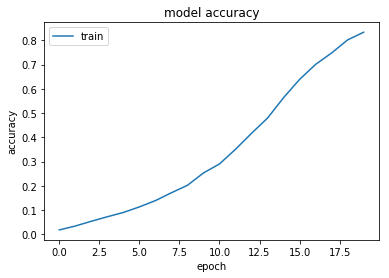

In [30]:
# summarize history for accuracy
plt.plot(model_hist.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


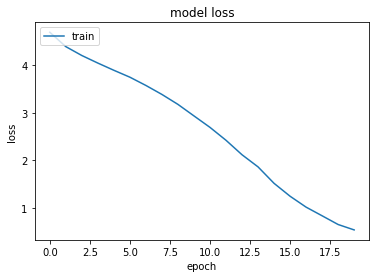

In [31]:
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Submission File

In [34]:
submission_data.head()

id        ...          yorkshire_terrier
0  c02cd35494405c5b848c9d1848f3f465        ...               1.392223e-12
1  a249e1b6752e56145f24f8cc4c8ccae8        ...               1.106805e-08
2  a0748da509a0111df34573d19701232e        ...               2.163440e-07
3  903c4482b966c733f4697e5ddc444d92        ...               3.344690e-05
4  b1efafd6a60fe9cc605793717edbf2c5        ...               3.862008e-08

[5 rows x 121 columns]